In [1]:
## UTIL

import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import torch
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam_version = "b"

if (sam_version == "l"):
	model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

	sam = sam_model_registry["vit_l"](checkpoint="./model/sam_vit_l_0b3195.pth")
	print("Using sam_vit_large")
else: 
	model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

	sam = sam_model_registry["vit_b"](checkpoint="./model/sam_vit_b_01ec64.pth")
	print("Using sam_vit_base")
 
sam.to(device=device)
predictor = SamPredictor(sam)

Using sam_vit_base


In [2]:
# Loss Definition

import torch.nn.functional as F 

def compute_loss(pred_masks, true_masks, pred_scores, true_scores):

  mask_loss = F.binary_cross_entropy_with_logits(pred_masks, true_masks)
  score_loss = F.mse_loss(pred_scores, true_scores)
  
  return mask_loss + score_loss

In [6]:
# Add images and masks to array

import os

panos_dir = "./data/training/0000/cropped_panos"
masks_dir = "./data/training/0000/cropped_masks"

image_paths = []
mask_paths = []

for filename in os.listdir(panos_dir):
	if filename.endswith((".jpg", ".png")):
		image_path = os.path.join(panos_dir, filename)
		mask_name = f"mask_{os.path.splitext(filename)[0]}.png" 
		mask_path = os.path.join(masks_dir, mask_name)

		if os.path.exists(mask_path):
				image_paths.append(image_path)
				mask_paths.append(mask_path)
		else:
				print(f"No mask for {image_path} found")

print(f"Amount of images found: {len(image_paths)}")
print(f"Amount of masks found: {len(mask_paths)}")


Amount of images found: 128
Amount of masks found: 128


In [12]:
# Dataset definition

class WindowSegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.transform = transform
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    mask = Image.open(self.mask_paths[idx]).convert("L")
    
    if (self.transform):
      image = self.transform(image)
      mask = self.transform(mask)
      
    return image, mask

transform = transforms.Compose([
	transforms.Resize((250, 250)),
 	transforms.ToTensor(),
])

dataset = WindowSegmentationDataset(image_paths, mask_paths, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [13]:
# Training

model.train()

optimizer = Adam(model.parameters(), lr=1e-4)

losses = []

for epoch in range(1): 
	counter = 0
	for images, masks in data_loader:
		images, masks = images.to(device), masks.to(device)
		counter = counter + 1
		inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
		image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
		outputs = model(**inputs)

		pred_masks = outputs.pred_masks

		# Choose best mask 
		scores = outputs.iou_scores.squeeze().tolist()
		max_index = scores.index(max(scores))
	
		best_mask = pred_masks[:, :, max_index]
		# print(f"Mask scores: {scores}")
		# print(f"Best mask: {max_index}")
 
		# Scale ground truth masks
		true_masks_resized = F.interpolate(masks, size=(256, 256), mode="bilinear", align_corners=False)

		# Convert to binary
		true_masks_resized = (true_masks_resized > 0.5).float()

		# Loss
		mask_loss = F.binary_cross_entropy_with_logits(best_mask, true_masks_resized)
		losses.append(mask_loss.item())
  
		# Backpropagation
		optimizer.zero_grad()
		mask_loss.backward()
		optimizer.step()
  
		# print(f"Epoch {epoch}, Loss: {mask_loss.item()}, Batch: {epoch}, Counter: {counter}")
		# print(torch.cuda.memory_allocated())
		torch.cuda.empty_cache()
	print(f"Epoch: {epoch}")


Epoch: 0


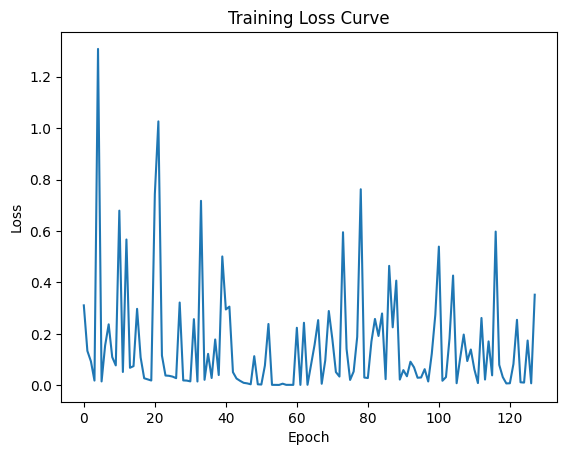

In [14]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

Text(0.5, 1.0, 'Original Image')

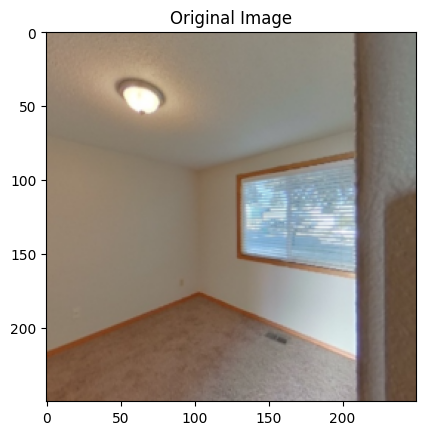

In [16]:
plt.imshow(images[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Original Image")

Text(0.5, 1.0, 'Mask')

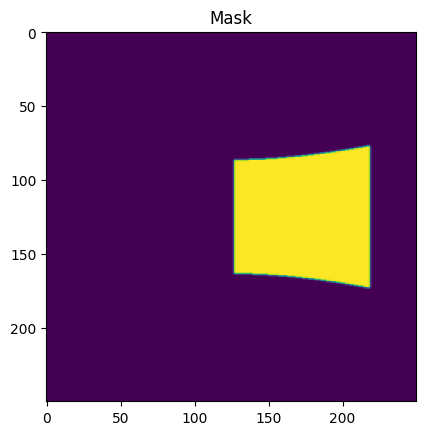

In [18]:
plt.imshow(masks[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Mask")